In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tfcvnn as cvnn

In [2]:
from scipy.io import loadmat

data = loadmat('C:/Users/saucourt/Coding/tensorflow_cvnn/synth_dset_step_lambda=1064nm_Nmodes=269_degen=True_len=5000_mirr=64_exp_noise_1_of_1.mat')

In [ ]:
data.keys()
print(data['intens'].shape)
print(data['phase_maps'].shape)
print(data['macropixels_energy'].shape)

In [ ]:
Y = np.sqrt(np.rollaxis(data['intens'], -1, 0))
F = np.rollaxis(data['fields'], -1, 0)
X = np.rollaxis(data['phase_maps'], -1, 0)
Z = np.sqrt(np.rollaxis(data['intens_transf'], -1, 0))
X = np.exp(1j * X) * np.expand_dims(np.sqrt(data['macropixels_energy']), 0)

N = X.shape[0]
X = np.reshape(X, (N, -1))
Y = np.reshape(Y, (N, -1))
F = np.reshape(F, (N, -1))
Z = np.reshape(Z, (N, -1))
n = X.shape[-1]
m = Y.shape[-1]
npx = int(np.sqrt(m))

gamma = 20
X = X[int(gamma*n):, :]
Y = Y[int(gamma*n):, :]
F = F[int(gamma*n):, :]
Z = Z[int(gamma*n):, :]

print(Y.shape, Y.dtype)
print(X.shape, X.dtype)

dm = np.copy(X)
cam = np.stack([Y, Z], axis=-1)

print(cam.shape, cam.dtype)

In [26]:
# Example usage: Build a simple model with the custom complex dense layer
activation = cvnn.activations.ComplexModLeakyReLU
layer = cvnn.layers.ComplexDense


inputs = tf.keras.Input(shape=(n,), dtype=tf.complex64)
# x = layer(20)(inputs)
# x = activation()(x)
# x = layer(1000)(inputs)
# x = activation()(x)
# # x = ComplexDense(100)(x)
outputs = layer(m)(inputs)
outputs = activation()(outputs)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64)]              0         
                                                                 
 complex_dense_2 (ComplexDen  (None, 4096)             532480    
 se)                                                             
                                                                 
 complex_mod_leaky_re_lu_2 (  (None, 4096)             0         
 ComplexModLeakyReLU)                                            
                                                                 
Total params: 532,480
Trainable params: 532,480
Non-trainable params: 0
_________________________________________________________________


In [9]:
from tfcvnn.losses import Pearson, SSIM

def fft2(field: tf.Tensor, normalize: bool = True) -> tf.Tensor:
    ft = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(field)))
    if normalize:
        field_shape = field.shape
        numel_image = tf.math.reduce_prod(field_shape[-2:])
        return ft / tf.cast(tf.math.sqrt(tf.cast(numel_image, tf.float64)), ft.dtype)
    else:
        return ft
    

def scaled_sigmoid(x: tf.Tensor, amp: float, coeff: float, offset: float,
                       dynamic: float = 1, dynamic_scaling: bool = True,
                       invert: bool = False,) -> tf.Tensor:
    sign = -1 if invert else 1
    if dynamic_scaling:
        x = x / dynamic
    arg = sign * coeff * (x - offset)
    return amp * tf.nn.sigmoid(arg)

def _make_new_fourier_prediction(y_pred_cplx: tf.Tensor) -> tf.Tensor:
    z_pred_cplx = fft2(y_pred_cplx, normalize=True)
    return z_pred_cplx


scaled_sigmoid_params = dict(amp=1, coeff=30, offset=0.01, dynamic=1, invert=True,)


def custom_loss(y_true, y_pred):
    y_true, z_true = y_true[..., 0], y_true[..., 1]
    y_true = tf.reshape(y_true, (-1, 64, 64))
    z_true = tf.reshape(z_true, (-1, 64, 64))
    y_pred = tf.reshape(y_pred, (-1, 64, 64))

    y_pred_pad = tf.pad(y_pred, [[0, 0], [32, 32], [32, 32]])
    z_pred_pad = _make_new_fourier_prediction(y_pred_pad)

    y_true = tf.pad(y_true, [[0, 0], [32, 32], [32, 32]])
    z_true = tf.pad(z_true, [[0, 0], [32, 32], [32, 32]])

    loss_fn1 = Pearson(inversed=False, squared=False)
    loss_fn2 = SSIM(inversed=False, squared=False, max_val=1, filter_size=7)

    loss1 = 1 - loss_fn1(tf.abs(y_pred_pad), tf.abs(y_true))
    loss2 = 1 - loss_fn2(tf.abs(z_pred_pad), tf.abs(z_true))

    return loss1 + loss2 * scaled_sigmoid(loss1, **scaled_sigmoid_params)




In [ ]:
from tfcvnn.losses import Dynamic_Pearson_MMF_and_SSIM_Fourier_v3

scaled_sigmoid_params = dict(amp=1, coeff=30, offset=0.01, dynamic=1, invert=True,)
loss_params = dict(pad_to=128, weights=(1, 1), squared=False, energy_regularization=True, energy_reg_weight=1,
                   max_val=1, filter_size=11, scaled_sigmoid_settings=scaled_sigmoid_params,)

loss_fn = custom_loss

x_tf = tf.cast(tf.convert_to_tensor(dm), tf.complex64)
y_tf = tf.cast(tf.convert_to_tensor(cam), tf.complex64)
batch_size = 32
validation_split = 0.2

num_samples = x_tf.shape[0]
num_val_samples = int(validation_split * num_samples)

# Shuffle and split the data into training and validation sets
dataset = tf.data.Dataset.from_tensor_slices((x_tf, y_tf))
dataset = dataset.shuffle(buffer_size=num_samples)

# Create training and validation datasets
train_dataset = dataset.skip(num_val_samples).batch(batch_size)
val_dataset = dataset.take(num_val_samples).batch(batch_size)

# Compile the model with a complex loss function
reduce_lr_callback_params = dict(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6, cooldown=2, min_delta=1e-2, verbose=1,)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_callback_params)

adam_params = dict(learning_rate=1e-3, beta_1=0.9)
optimizer = tf.keras.optimizers.Adam(**adam_params)

# model.compile(optimizer=optimizer, loss='mse')
model.compile(optimizer=optimizer, loss=loss_fn)

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[reduce_lr_callback])


In [20]:
def _tf_get_predictions_from_batched_dataset(model, dataset,):
    preds, trues = [], []
    for x, y in dataset:
        preds.append(model.predict(x, verbose = 0))   # Predict on the current batch
        trues.append(y.numpy())          # Collect the true labels of the current batch
    # Now concatenate them if necessary
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    return preds, trues

f_tf = tf.cast(tf.convert_to_tensor(F), tf.complex64)
dataset_cplx = tf.data.Dataset.from_tensor_slices((x_tf, f_tf)).batch(batch_size)
# preds, trues = _tf_get_predictions_from_batched_dataset(model, val_dataset)

preds, trues = _tf_get_predictions_from_batched_dataset(model, dataset_cplx)

In [21]:
print(preds.shape, preds.dtype)
print(trues.shape, trues.dtype)

z_trues = trues[..., 1]
y_trues = trues[..., 0]

(3720, 4096) complex64
(3720, 4096) complex64


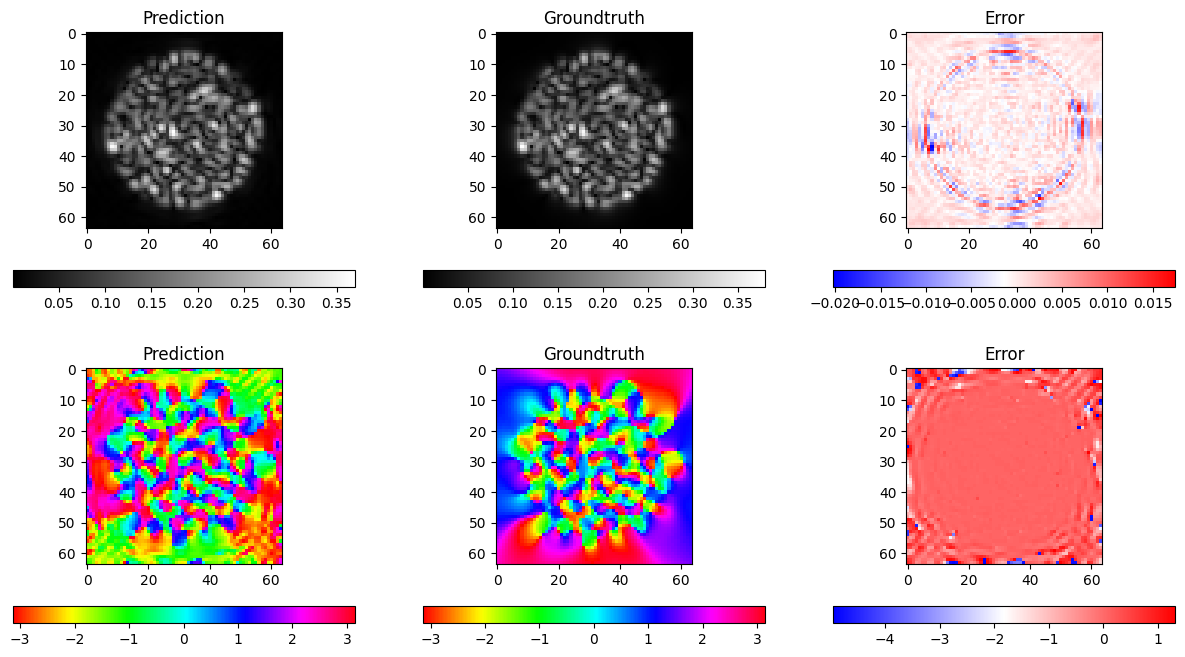

In [25]:
idx = np.random.randint(preds.shape[0])

plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(preds[idx, ...]).reshape(npx, npx), cmap='gray')
plt.title('Prediction')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(trues[idx, ...]).reshape(npx, npx), cmap='gray')
plt.title('Groundtruth')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 3)
plt.imshow(np.abs(preds[idx, ...]).reshape(npx, npx) - np.abs(trues[idx, ...]).reshape(npx, npx), cmap='bwr')
plt.title('Error')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 4)
plt.imshow(np.angle(preds[idx, ...]).reshape(npx, npx), cmap='hsv')
plt.title('Prediction')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 5)
plt.imshow(np.angle(trues[idx, ...]).reshape(npx, npx), cmap='hsv')
plt.title('Groundtruth')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 6)
phi_error = np.angle(np.exp(1j * (np.angle(preds[idx, ...]).reshape(npx, npx) - np.angle(trues[idx, ...]).reshape(npx, npx))))
plt.imshow(phi_error - np.mean(phi_error), cmap='bwr')
plt.title('Error')
plt.colorbar(location='bottom')